In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

In [3]:
from mejiro.lenses import lens_util
detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

Number of detectable lenses: 1993


In [4]:
snr_dict = {}
for lens in detectable_lenses:
    snr_dict[lens.uid] = lens.magnification

In [5]:
model_files = glob(f'{pipeline_dir}/03/**/array_*_F129.npy')
print(f'{len(model_files)} model(s) found')

1993 model(s) found


In [6]:
image_files = glob(f'{pipeline_dir}/04/**/galsim_*_F129.npy')
print(f'{len(image_files)} model(s) found')

1993 model(s) found


In [7]:
color_files = glob(f'{pipeline_dir}/05/**/galsim_color_*.npy')
print(f'{len(color_files)} color file(s) found')

1993 color file(s) found


In [8]:
# assert len(model_files) == len(image_files) == len(color_files)

In [9]:
dim = 10

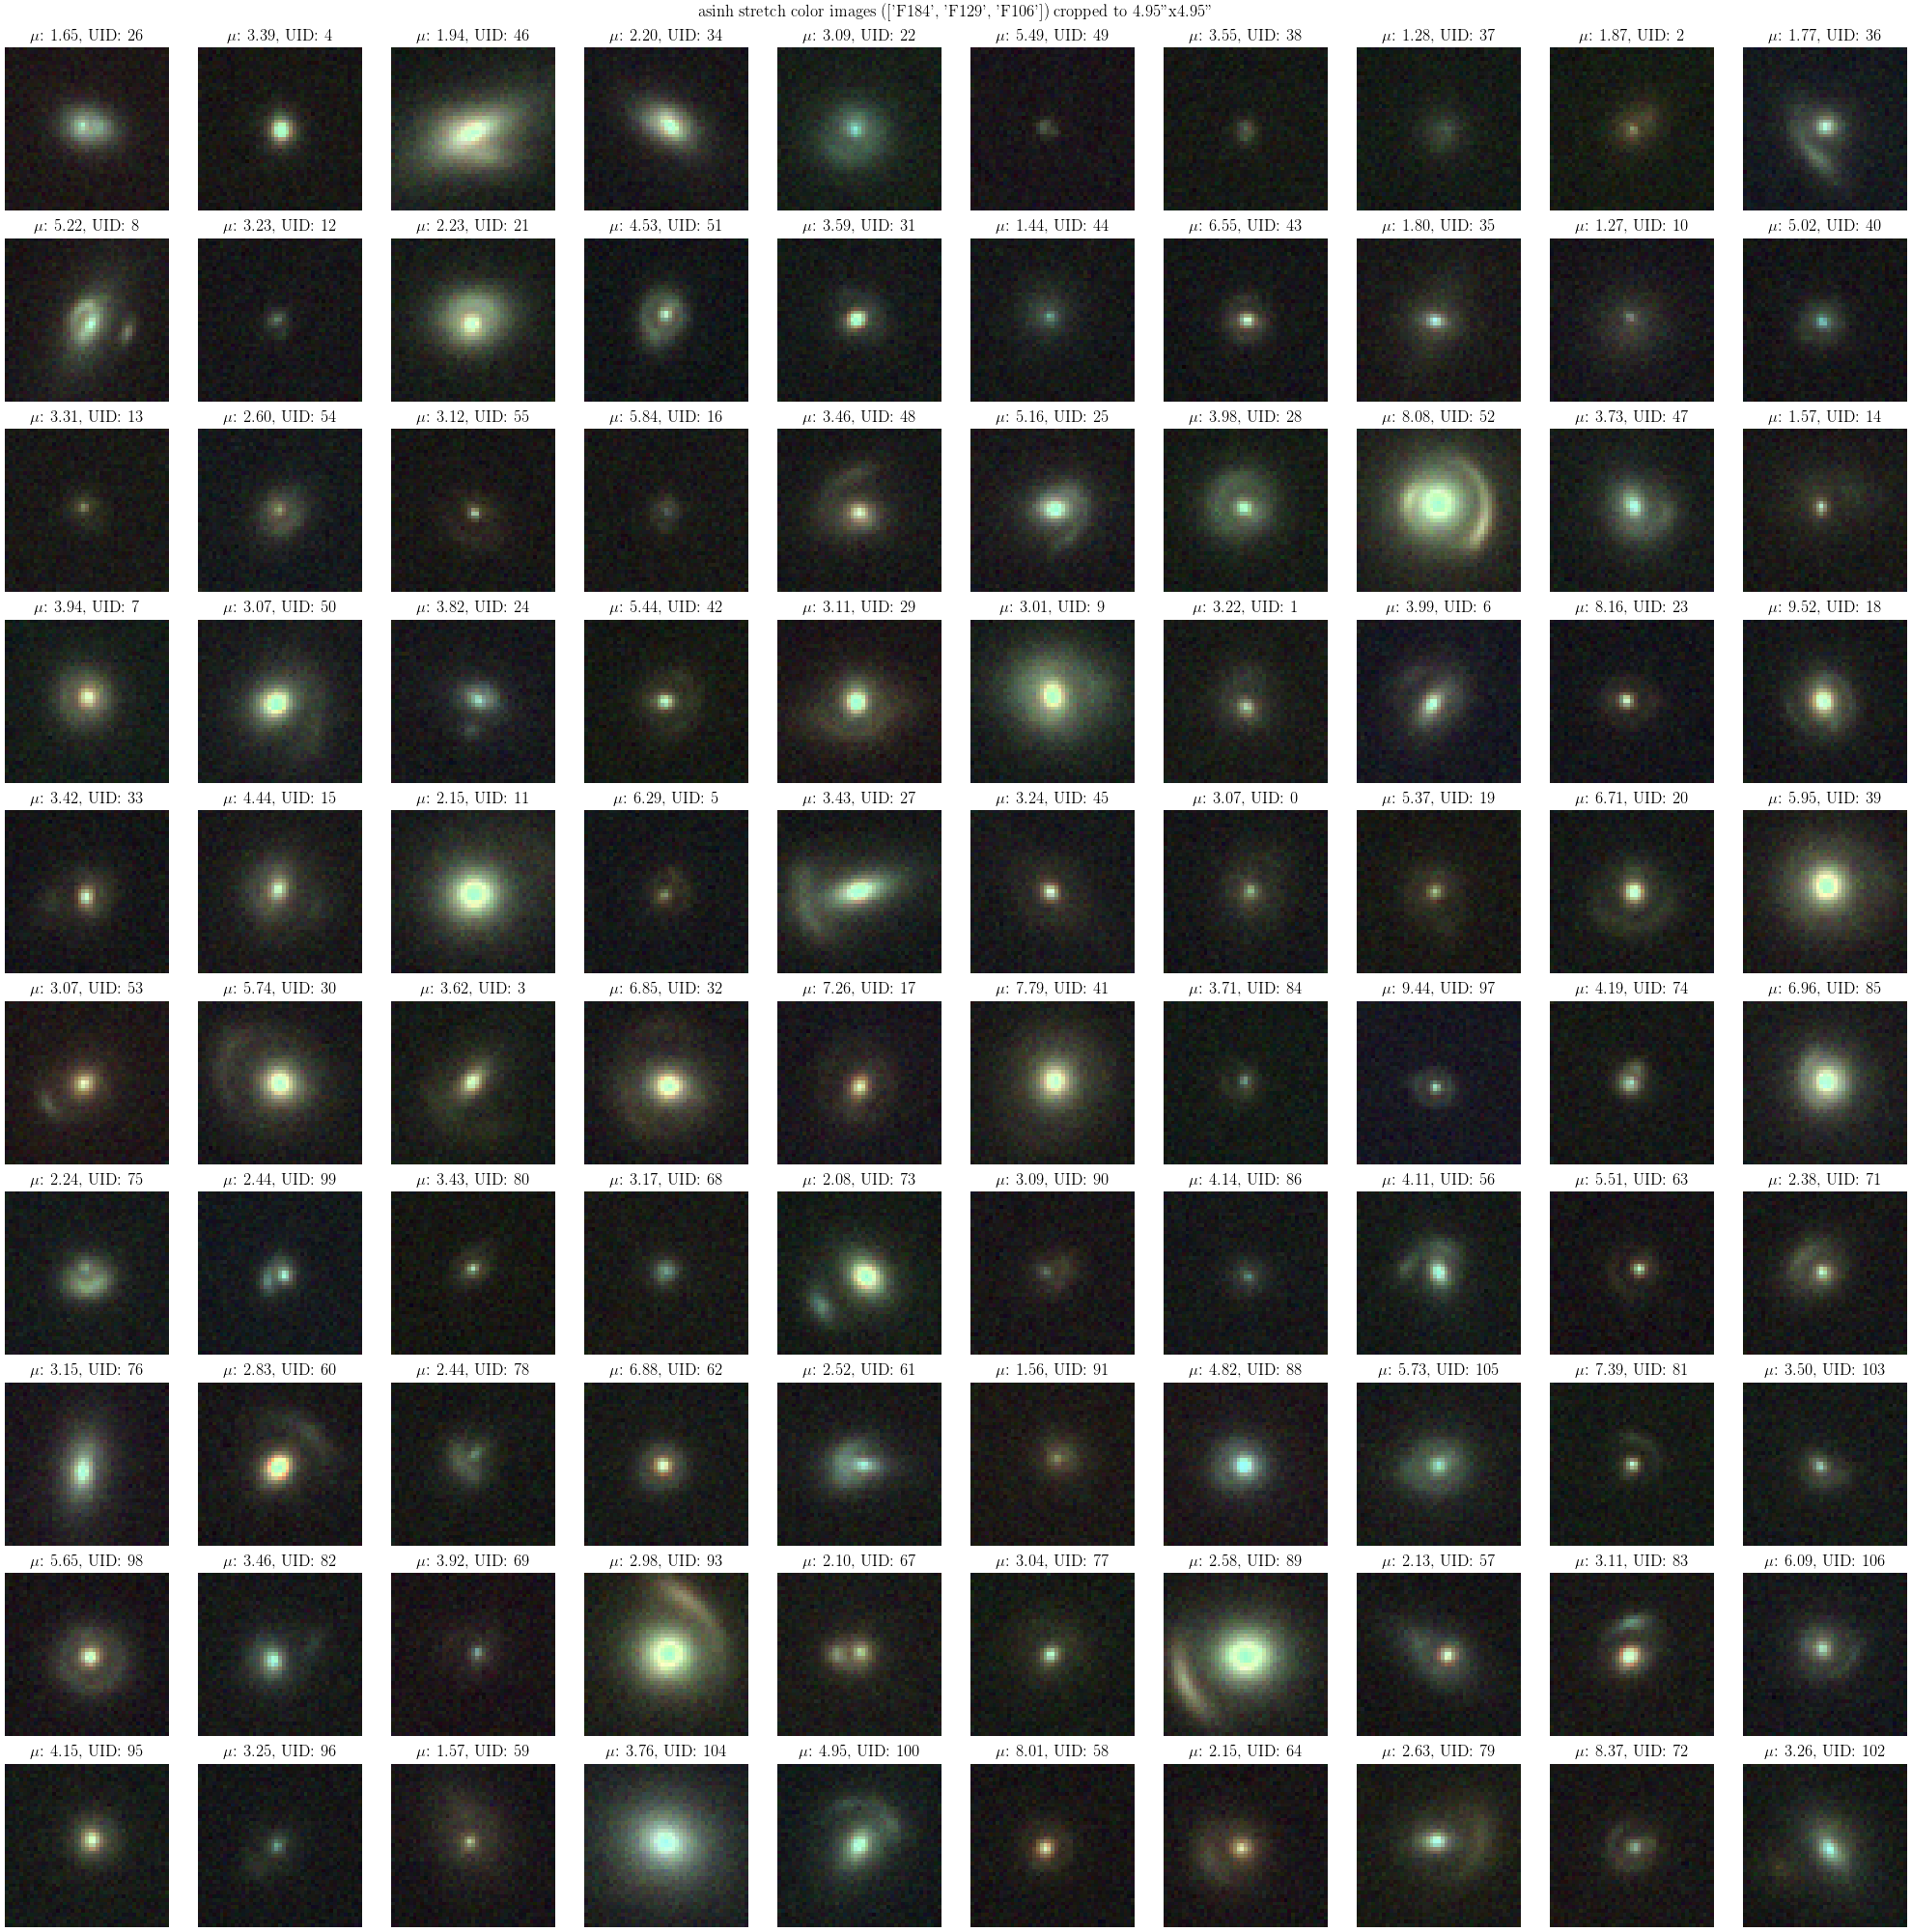

In [10]:
f, ax = plt.subplots(dim, dim, figsize=(20, 20), constrained_layout=True)

i, j = 0, 0
for uid, snr in snr_dict.items():
    # load color image
    file = [f for f in color_files if uid in f][0]
    assert os.path.exists(file), f'File not found: {file}'
    color = np.load(file)

    ax[i][j].imshow(util.center_crop_image(color, (45, 45)))
    ax[i][j].set_axis_off()
    ax[i][j].set_title(r'$\mu$: ' + f'{snr:.2f}, UID: {int(uid)}')

    j += 1
    if j == dim:
        j = 0
        i += 1
    if i == dim:
        break

rgb_bands = pipeline_params['rgb_bands']
plt.suptitle(f'asinh stretch color images ({rgb_bands}) cropped to 4.95"x4.95"')
plt.savefig(os.path.join(figure_dir, 'magnification_sanity_check_color.png'))
plt.show()

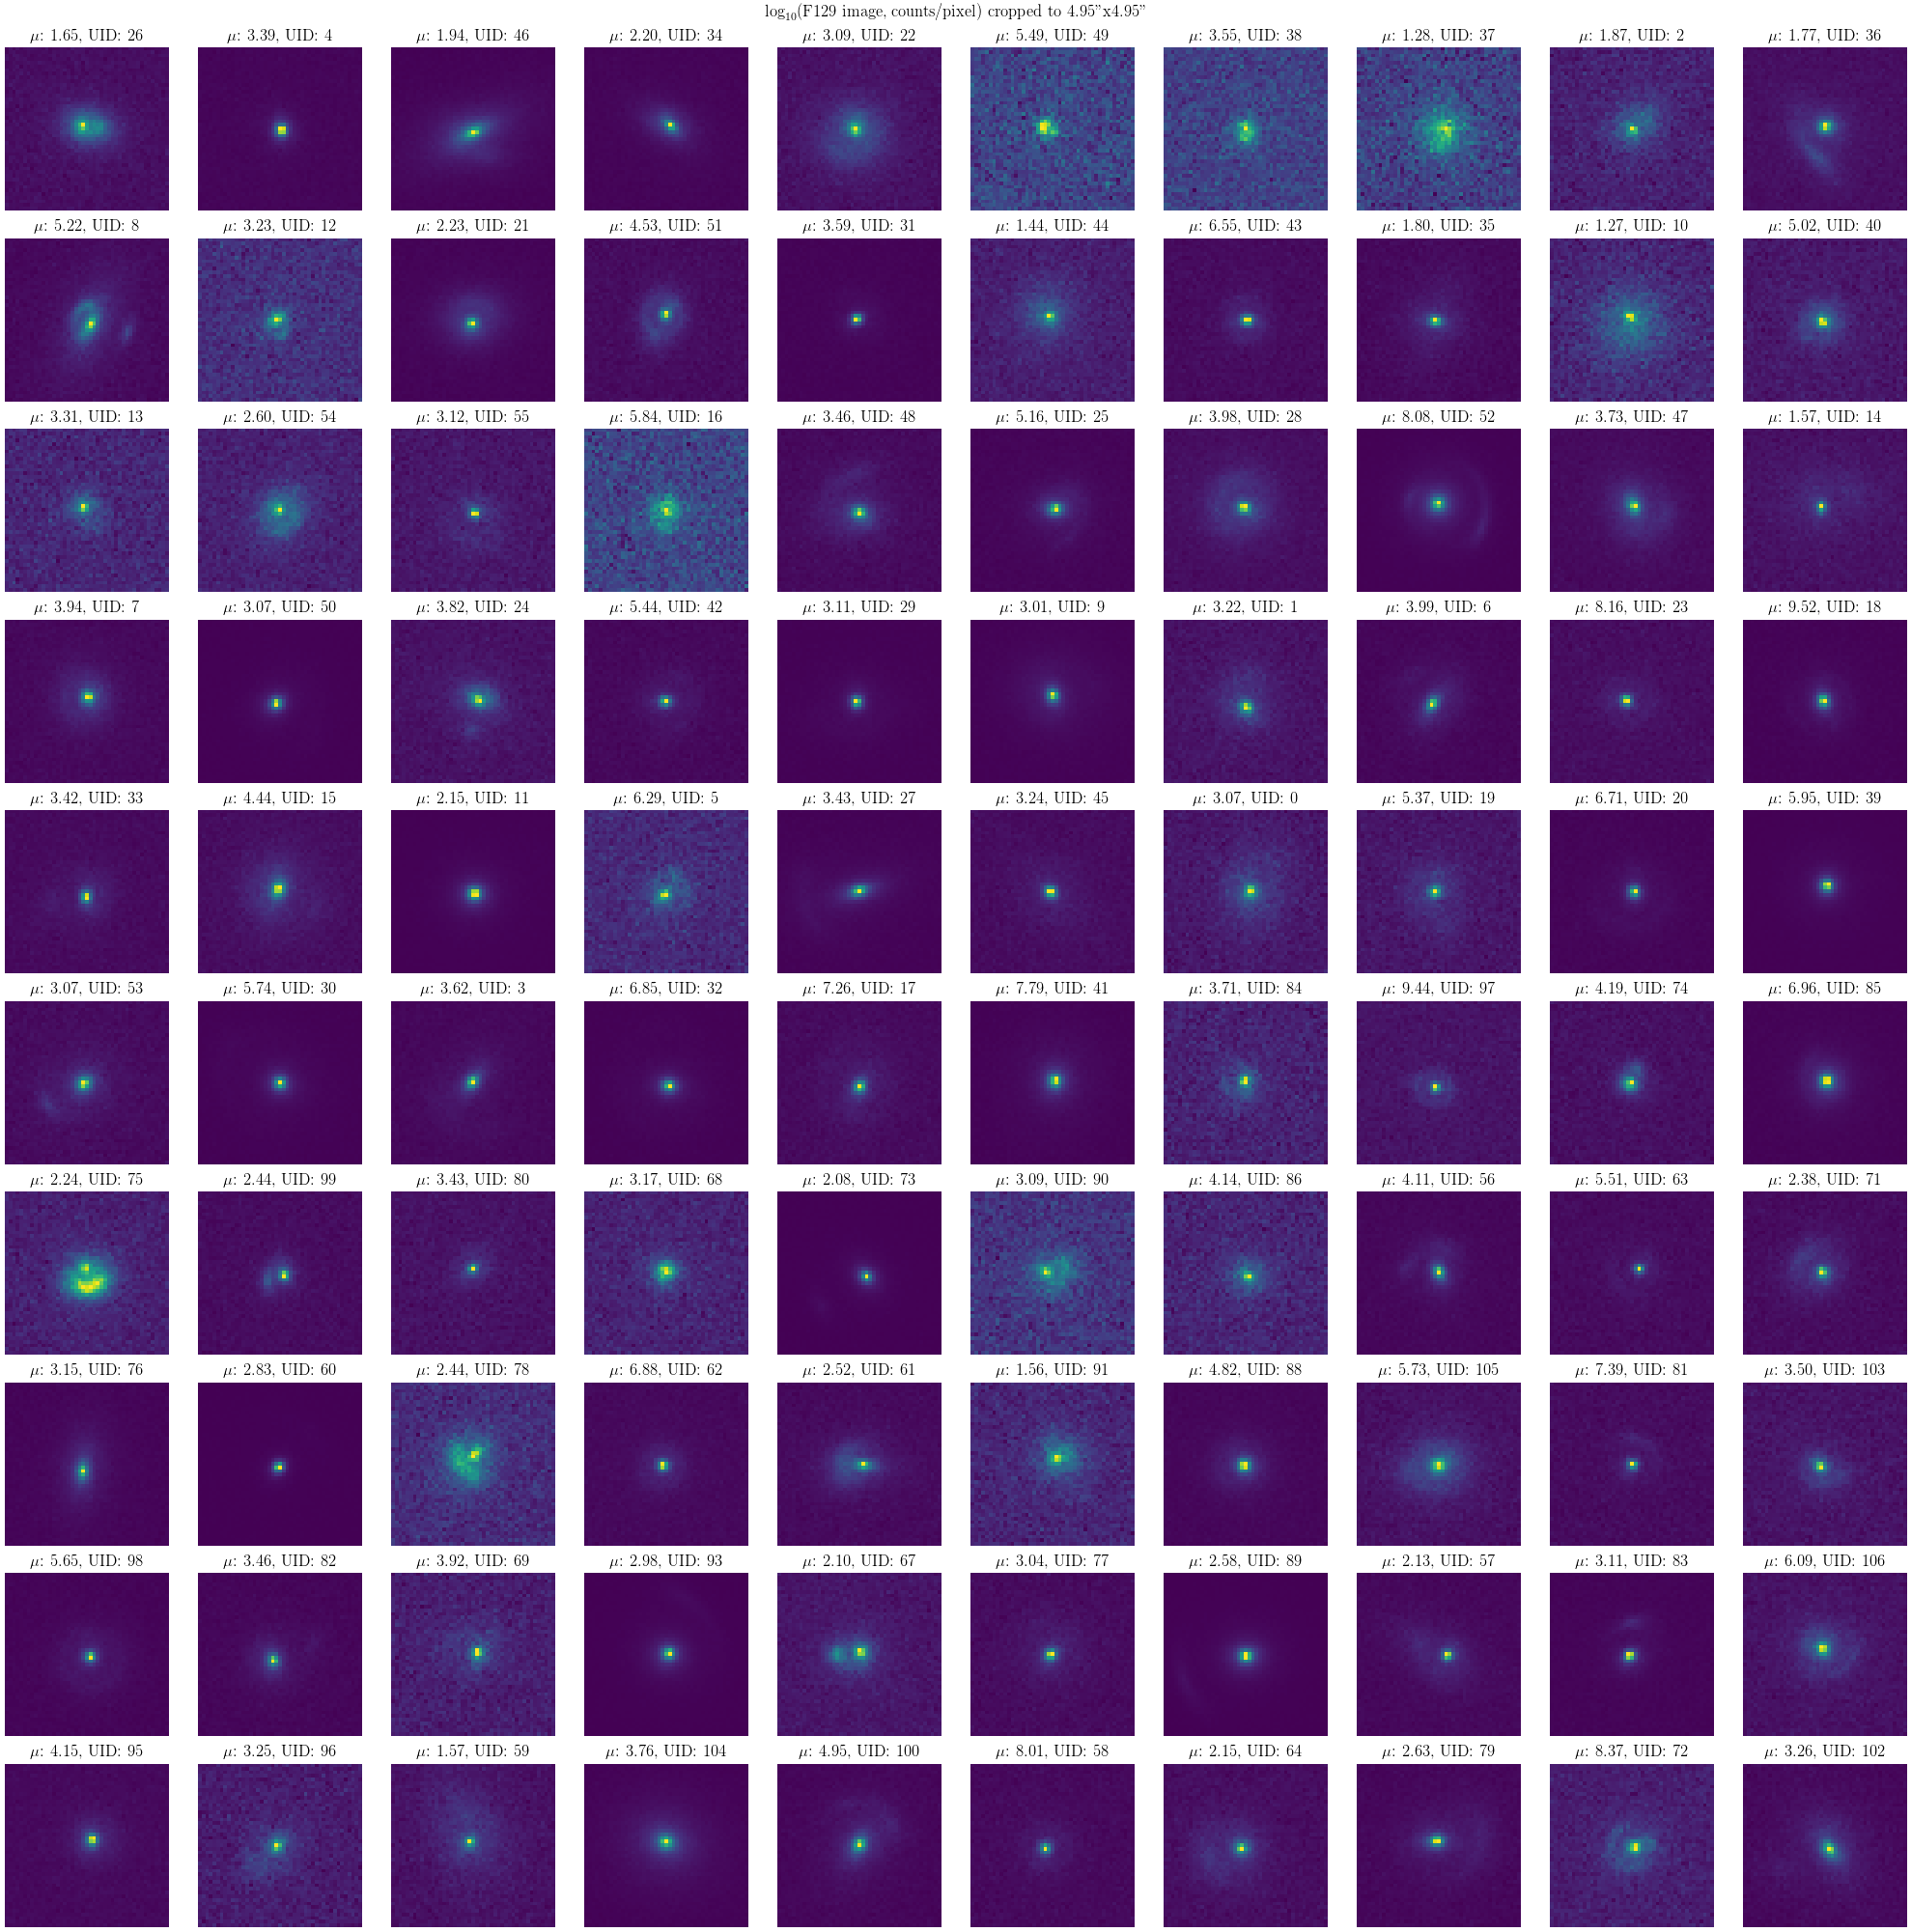

In [11]:
f, ax = plt.subplots(dim, dim, figsize=(20, 20), constrained_layout=True)

i, j = 0, 0
for uid, snr in snr_dict.items():
    # load model
    file = [f for f in image_files if uid in f][0]
    assert os.path.exists(file), f'File not found: {file}'
    image = np.load(file)
    image = util.center_crop_image(image, (45, 45))
    ax[i][j].imshow(image, vmin=np.min(image), vmax=np.max(image))
    ax[i][j].set_axis_off()
    ax[i][j].set_title(r'$\mu$: ' + f'{snr:.2f}, UID: {int(uid)}')

    j += 1
    if j == dim:
        j = 0
        i += 1
    if i == dim:
        break

plt.suptitle(r'$\log_{10}(\textrm{F129 image, counts/pixel})$ cropped to 4.95"x4.95"')
plt.savefig(os.path.join(figure_dir, 'magnification_sanity_check_f129.png'))
plt.show()